In [1]:
import os

In [2]:
type1 = str('U shaped parts_025_1')
type2 = "U-shaped_parts_0025"

sep = '_'
str_1 = sep.join(type1.strip("_")[0])
str_1


'U'

In [3]:
type1[:3]

'U s'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms, datasets

In [5]:
!pip install shap
import shap

     |████████████████████████████████| 358kB 7.2MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489392 sha256=79cb704cbe572638d0716318a0c6afa91fc428c9297036a8b00b4bb2e5bc75b1
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv_layers = nn.Sequential(
       nn.Conv2d(1, 10, 5),
       nn.MaxPool2d(2),
       nn.ReLU(),
       nn.Conv2d(10,20,5),
       nn.Dropout(),
       nn.MaxPool2d(2),
       nn.ReLU()
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(320, 50),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(50,10),
        nn.Softmax(1)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(-1,320)
    x = self.fc_layers(x)
    return x 

In [17]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = Net().to(device)
batch_size = 128
epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.5)

In [18]:
transform = transforms.Compose([ 
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307, ), (0.3081, ))
])

training_set = datasets.MNIST('data/', train = True, transform = transform, download=True)
test_set = datasets.MNIST('data/', train = False, transform = transform, download = True)
train_loader = torch.utils.data.DataLoader(training_set, batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle = True)

In [19]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out.log(), target)
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

In [20]:
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      out = model(data)
      test_loss += F.nll_loss(out.log(), target).item()
      pred = out.max(1, keepdim = True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
  100. * correct / len(test_loader.dataset)))

In [21]:
for epoch in range(1, epochs+1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335134
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.058065
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.786131
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.780953
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.526633

Test set: Average loss: 0.0027, Accuracy: 9336/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.531359
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.441742
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.433000
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.560020
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.274215

Test set: Average loss: 0.0015, Accuracy: 9579/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.297974
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.435883
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.236686
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.412129
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.175588

Test set: Average loss: 0.0011, Accuracy: 9660/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.226820
Train Epoch: 4 [12800/60000 (21%)]	Lo

## Model Interpretation

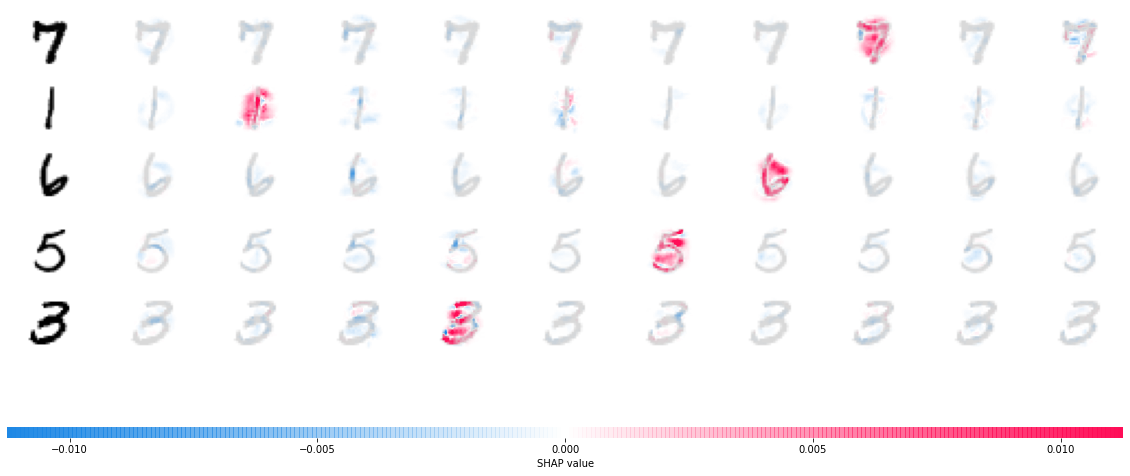

In [22]:
batch = next(iter(test_loader))
images, targets = batch
background = images[:100].to(device)
test_images = images[100:105].to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)
